### Library Imports and Device Configuration

This cell imports the required libraries for data handling (Pandas, NumPy), 
deep learning (PyTorch), data loading and augmentation (TorchVision), 
and visualization (Matplotlib). It also sets the computation device to GPU 
if available, otherwise defaults to CPU.

In [14]:
import torch
import math
from torch import nn
import pandas as pd
import numpy as np
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Definition of Bayesian Neural Network Components

This section defines the core components of a Bayesian Neural Network:

- **`ScaleMixtureGaussian`**: Represents a prior distribution as a scale mixture of two Gaussians with different standard deviations.
- **`GaussianNode`**: Encapsulates the variational posterior over weights and biases, providing sampling and log-probability methods.
- **`BayesianLinear`**: Implements a fully connected linear layer where weights and biases are represented by `GaussianNode`s, and regularized by the `ScaleMixtureGaussian` prior.
- **`BayesianNetwork`**: Constructs a feedforward neural network using multiple `BayesianLinear` layers with ReLU activations. It includes methods to compute the log prior, variational posterior, negative log-likelihood, and to estimate the Evidence Lower Bound (ELBO) loss through multiple forward samples.


In [15]:
# Define a scale mixture of two Gaussian distributions used as prior
class ScaleMixtureGaussian:                               
    def __init__(self, mixture_weight, stddev_1, stddev_2):
        self.mixture_weight = mixture_weight
        self.stddev_1 = stddev_1
        self.stddev_2 = stddev_2
        self.gaussian1 = torch.distributions.Normal(0, stddev_1)
        self.gaussian2 = torch.distributions.Normal(0, stddev_2)

    def log_prob(self, x):
        prob1 = torch.exp(self.gaussian1.log_prob(x))
        prob2 = torch.exp(self.gaussian2.log_prob(x))
        return torch.log(self.mixture_weight * prob1 + (1 - self.mixture_weight) * prob2).sum()


# Define a Gaussian variational distribution for weights or biases
class GaussianNode:
    def __init__(self, mean, rho_param):
        self.mean = mean
        self.rho_param = rho_param
        self.normal = torch.distributions.Normal(0, 1)
    
    def sigma(self):
        # Softplus function to ensure positivity of standard deviation
        return torch.log1p(torch.exp(self.rho_param))

    def sample(self):
        # Sample using the reparameterization trick
        epsilon = self.normal.sample(self.rho_param.size()).cuda()
        return self.mean + self.sigma() * epsilon
    
    def log_prob(self, x):
        # Log-probability under the variational distribution
        return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma()) - ((x - self.mean) ** 2) / (2 * self.sigma() ** 2)).sum()


# Bayesian fully connected linear layer
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, mu_init, rho_init, prior_init):
        super().__init__()
        self.weight_mean = nn.Parameter(torch.empty(out_features, in_features).uniform_(*mu_init))
        self.weight_rho_param = nn.Parameter(torch.empty(out_features, in_features).uniform_(*rho_init))
        self.weight = GaussianNode(self.weight_mean, self.weight_rho_param)

        self.bias_mean = nn.Parameter(torch.empty(out_features).uniform_(*mu_init))
        self.bias_rho_param = nn.Parameter(torch.empty(out_features).uniform_(*rho_init))
        self.bias = GaussianNode(self.bias_mean, self.bias_rho_param)

        # Define the prior distributions for weights and biases
        self.weight_prior = ScaleMixtureGaussian(prior_init[0], math.exp(prior_init[1]), math.exp(prior_init[2]))
        self.bias_prior = ScaleMixtureGaussian(prior_init[0], math.exp(prior_init[1]), math.exp(prior_init[2]))

        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x):
        weight = self.weight.sample()
        bias = self.bias.sample()
        return nn.functional.linear(x, weight, bias)


# Bayesian neural network model with 3 BayesianLinear layers
class BayesianNetwork(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']
        self.mu_init = model_params['mu_init']
        self.rho_init = model_params['rho_init']
        self.prior_init = model_params['prior_init']

        self.fc1 = BayesianLinear(self.input_shape, self.hidden_units, self.mu_init, self.rho_init, self.prior_init)
        self.fc1_activation = nn.ReLU()
        self.fc2 = BayesianLinear(self.hidden_units, self.hidden_units, self.mu_init, self.rho_init, self.prior_init)
        self.fc2_activation = nn.ReLU()
        self.fc3 = BayesianLinear(self.hidden_units, self.classes, self.mu_init, self.rho_init, self.prior_init)
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape)
        x = self.fc1_activation(self.fc1(x))
        x = self.fc2_activation(self.fc2(x))
        x = self.fc3(x)
        return x

    def log_prior(self):
        return self.fc1.log_prior + self.fc2.log_prior + self.fc3.log_prior
    
    def log_variational_posterior(self):
        return self.fc1.log_variational_posterior + self.fc2.log_variational_posterior + self.fc3.log_variational_posterior

    def get_nll(self, outputs, target, sigma=1.):
        if self.experiment == 'regression':
            return -torch.distributions.Normal(outputs, sigma).log_prob(target).sum()
        elif self.experiment == 'classification':
            return nn.CrossEntropyLoss(reduction='sum')(outputs, target)

    def sample_elbo(self, x, target, beta, samples, sigma=1.):
        log_prior = torch.zeros(1).to(device)
        log_variational_posterior = torch.zeros(1).to(device)
        negative_log_likelihood = torch.zeros(1).to(device)

        for _ in range(samples):
            output = self.forward(x)
            log_prior += self.log_prior()
            log_variational_posterior += self.log_variational_posterior()
            negative_log_likelihood += self.get_nll(output, target, sigma)

        log_prior *= beta / samples
        log_variational_posterior *= beta / samples
        negative_log_likelihood /= samples

        loss = log_variational_posterior - log_prior + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

### Definition of Baseline MLP Models

This section defines two baseline feedforward neural networks:

- **`MLP`**: A standard multilayer perceptron with two hidden layers and ReLU activations.
- **`MLP_Dropout`**: A variation of the MLP that includes dropout layers for regularization, useful for uncertainty estimation (e.g., via Monte Carlo Dropout).

Both models take as input the `model_params` dictionary to configure architecture and behavior. The dropout-enabled model also includes a method to activate dropout at inference time.


In [16]:
class MLP(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']

        self.net = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, self.classes)
        )
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape)  # Flatten input for fully connected layers
        return self.net(x)


class MLP_Dropout(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']

        self.net = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_units, self.hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_units, self.classes)
        )
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape)  # Flatten input
        return self.net(x)

    def enable_dropout(self):
        """Enable dropout layers during inference (e.g., for Monte Carlo Dropout)."""
        for m in self.modules():
            if isinstance(m, nn.Dropout):
                m.train()

### Experiment Configuration Classes

This section defines configuration classes for different experiment types:

- **`RegConfig`**: Configuration for a regression task, including training size, number of samples for Monte Carlo estimation, noise tolerance, and prior parameters.
- **`RLConfig`**: Configuration for a reinforcement learning or streaming-style task using a mushroom dataset. Includes buffer management and learning rate settings.
- **`ClassConfig`**: Configuration for a classification task (e.g., MNIST), specifying training hyperparameters, architecture size, and dropout usage.

Each class encapsulates relevant hyperparameters and prior settings used across Bayesian and standard models.

In [17]:
class RegConfig:
    """Configuration for a regression experiment."""
    train_size = 1024
    batch_size = 128
    lr = 1e-3
    epochs = 1000
    train_samples = 5           # Number of Monte Carlo samples for training
    test_samples = 10           # Number of Monte Carlo samples for evaluation
    num_test_points = 400
    experiment = 'regression'
    hidden_units = 400
    noise_tolerance = 0.1       # Sigma for Gaussian log-likelihood
    mu_init = [-0.2, 0.2]       # Range for initializing means
    rho_init = [-5, -4]         # Range for initializing rho parameters
    prior_init = [0.5, 0, -6]   # Mixture weight, log(stddev_1), log(stddev_2)


class RLConfig:
    """Configuration for a reinforcement learning or stream-like regression setup."""
    data_dir = '/kaggle/input/mushroom/agaricus-lepiota.data'
    batch_size = 64
    num_batches = 64
    buffer_size = batch_size * num_batches  # Rolling buffer size for data stream
    lr = 1e-4
    training_steps = 50000
    experiment = 'regression'
    hidden_units = 100
    mu_init = [-0.2, 0.2]
    rho_init = [-5, -4]
    prior_init = [0.5, 0, -6]


class ClassConfig:
    """Configuration for a classification experiment (e.g., MNIST)."""
    batch_size = 128
    lr = 1e-3
    epochs = 600
    hidden_units = 1200
    experiment = 'classification'
    dropout = True
    train_samples = 1           # Lower value for faster training
    test_samples = 10
    x_shape = 28 * 28           # Input shape (flattened image)
    classes = 10                # Number of output classes
    mu_init = [-0.2, 0.2]
    rho_init = [-5, -4]
    prior_init = [0.75, 0, -7]

### Dataset Preparation Utilities

This section defines utility components for preparing data for training:

- **`PrepareData`**: A custom PyTorch `Dataset` class that wraps input features and labels, ensuring they are converted to tensors if needed.
- **`read_data_rl`**: Loads and preprocesses the mushroom dataset for classification. It applies label encoding and one-hot encoding to categorical features and class labels.
- **`create_data_reg`**: Generates synthetic regression data using a combination of sinusoidal functions and noise, suitable for benchmarking Bayesian models.


In [18]:
class PrepareData(Dataset):
    """Custom PyTorch Dataset to wrap input features and targets."""
    def __init__(self, X, y):
        self.X = torch.from_numpy(X) if not torch.is_tensor(X) else X
        self.y = torch.from_numpy(y) if not torch.is_tensor(y) else y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def read_data_rl(data_dir):
    """
    Load and preprocess the mushroom dataset.
    Applies label encoding and one-hot encoding to categorical features.
    Returns: one-hot encoded features (numpy array), encoded class labels (numpy array)
    """
    df = pd.read_csv(data_dir, sep=',', header=None)
    df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
                  'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
                  'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
                  'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']
    
    X = df.drop(columns='class')
    Y = df['class']

    # Encode class labels
    label_encoder = preprocessing.LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)

    # Encode each categorical feature
    oh_X = X.copy()
    for feature in X.columns:
        oh_X[feature] = preprocessing.LabelEncoder().fit_transform(X[feature])

    # One-hot encode the entire dataset
    oh_encoder = preprocessing.OneHotEncoder()
    oh_X = oh_encoder.fit_transform(oh_X).toarray()

    return oh_X, Y_encoded


def create_data_reg(train_size):
    """
    Generate synthetic regression data:
    y = x + 0.3*sin(2π(x+ε)) + 0.3*sin(4π(x+ε)) + ε
    where ε is Gaussian noise.
    """
    np.random.seed(0)
    xs = np.random.uniform(low=0., high=0.6, size=train_size)
    eps = np.random.normal(loc=0., scale=0.02, size=train_size)

    ys = xs + 0.3 * np.sin(2 * np.pi * (xs + eps)) + 0.3 * np.sin(4 * np.pi * (xs + eps)) + eps

    xs = torch.from_numpy(xs).reshape(-1, 1).float()
    ys = torch.from_numpy(ys).reshape(-1, 1).float()

    return xs, ys

### Regression Prediction Visualization

This function generates a visualization of a Bayesian regression model’s predictive distribution:

- **Median Posterior Predictive**: The central estimate (median) of the model’s output.
- **Range**: The full range (0th to 100th percentile) of the predictions, shown with a light shaded area.
- **Interquartile Range**: The middle 50% of predictions (25th to 75th percentile), shown with a darker shaded area.
- **Training Data**: The original training points are plotted for reference.

This plot helps illustrate model uncertainty and data fit in the context of probabilistic regression.


In [19]:
def create_regression_plot(X_test, y_test, train_ds):
    """
    Plot the predictive distribution of a Bayesian regression model.
    
    Args:
        X_test (np.ndarray): Test input values.
        y_test (np.ndarray): Predictive samples (shape: [samples, test_points]).
        train_ds (torch.utils.data.DataLoader): DataLoader containing training data.

    Returns:
        None. Displays the matplotlib plot.
    """
    fig = plt.figure(figsize=(9, 6))

    # Plot the median prediction
    plt.plot(X_test, np.median(y_test, axis=0), label='Median Posterior Predictive')

    # Plot full predictive range (0–100 percentile)
    plt.fill_between(
        X_test.reshape(-1),
        np.percentile(y_test, 0, axis=0),
        np.percentile(y_test, 100, axis=0),
        alpha=0.2,
        color='orange',
        label='Range'
    )

    # Plot interquartile range (25–75 percentile)
    plt.fill_between(
        X_test.reshape(-1),
        np.percentile(y_test, 25, axis=0),
        np.percentile(y_test, 75, axis=0),
        alpha=0.4,
        label='Interquartile Range'
    )

    # Plot training data
    plt.scatter(
        train_ds.dataset.X,
        train_ds.dataset.y,
        label='Training data',
        marker='x',
        alpha=0.5,
        color='k',
        s=2
    )

    plt.xlim([-0.6, 1.4])
    plt.ylim([-1.5, 1.5])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=14)
    plt.title('Bayesian Regression Predictive Uncertainty', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Bayesian Neural Network Classifier (BNN_Classification)

This class defines a wrapper for training and evaluating a Bayesian neural network for classification tasks.

Key functionalities include:
- **Initialization**: Builds a `BayesianNetwork` with specified architecture and prior parameters.
- **Training**: Uses ELBO-based optimization with Monte Carlo sampling and a custom β-scaling strategy per batch.
- **Prediction**: Averages multiple stochastic forward passes to estimate predictive probabilities.
- **Evaluation**: Computes accuracy over a test dataset using probabilistic predictions.

This class allows for modular experimentation with uncertainty-aware classification models.

In [20]:
class BNN_Classification:
    """
    Classification pipeline using a Bayesian Neural Network.
    Supports training, prediction with uncertainty, and evaluation.
    """
    def __init__(self, label, parameters):
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.classes = parameters['classes']
        self.mu_init = parameters['mu_init']
        self.rho_init = parameters['rho_init']
        self.prior_init = parameters['prior_init']
        self.best_acc = 0.0

        self.init_net(parameters)

    def init_net(self, parameters):
        """Initialize the Bayesian network and optimizer."""
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.classes,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment,
            'mu_init': self.mu_init,
            'rho_init': self.rho_init,
            'prior_init': self.prior_init,
        }

        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=100, gamma=0.5)

    def train_step(self, train_data):
        """Perform a full training epoch using ELBO loss with β-scaling."""
        self.net.train()
        for idx, (x, y) in enumerate(tqdm(train_data)):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1)
            x, y = x.to(device), y.to(device)

            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples)
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()

    def predict(self, X):
        """Make stochastic predictions using Monte Carlo sampling."""
        probs = torch.zeros(size=[self.batch_size, self.classes]).to(device)

        for _ in range(self.test_samples):
            outputs = self.net(X)
            probs += torch.nn.Softmax(dim=1)(outputs) / self.test_samples

        preds = torch.argmax(probs, dim=1)
        return preds, probs

    def evaluate(self, test_loader):
        """Evaluate model accuracy on a test set."""
        self.net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in tqdm(test_loader):
                X, y = X.to(device), y.to(device)
                preds, _ = self.predict(X)
                total += self.batch_size
                correct += (preds == y).sum().item()

        self.acc = correct / total
        print(f'{self.label} validation accuracy: {self.acc:.4f}')
        return self.acc

### Standard MLP Classifier (MLP_Classification)

This class defines a training and evaluation wrapper for a standard feedforward neural network (MLP) used in classification tasks.

Key functionalities include:
- **Initialization**: Configures a standard or dropout-regularized MLP based on input parameters.
- **Training**: Optimizes using SGD and cross-entropy loss over multiple batches.
- **Prediction**: Outputs both class predictions and softmax probabilities.
- **Evaluation**: Computes classification accuracy on a test set.

This class is useful for comparing deterministic MLPs with Bayesian or uncertainty-aware models.


In [21]:
class MLP_Classification:
    """
    Classification wrapper for a standard MLP or MLP with dropout.
    Handles training, prediction, and evaluation.
    """
    def __init__(self, label, parameters):
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.classes = parameters['classes']
        self.best_acc = 0.0
        self.dropout = parameters['dropout']

        self.init_net(parameters)

    def init_net(self, parameters):
        """Initialize the MLP network and optimizer."""
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.classes,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment,
            'dropout': self.dropout,
        }

        self.net = MLP_Dropout(model_params).to(device)
        self.optimiser = torch.optim.SGD(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=100, gamma=0.5)

    def train_step(self, train_data):
        """Train the MLP for one full epoch using cross-entropy loss."""
        self.net.train()
        for _, (x, y) in enumerate(tqdm(train_data)):
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            loss = torch.nn.functional.cross_entropy(self.net(x), y, reduction='sum')
            self.loss_info = loss
            loss.backward()
            self.optimiser.step()

    def predict(self, X):
        """Predict class labels and softmax probabilities."""
        probs = torch.nn.Softmax(dim=1)(self.net(X))
        preds = torch.argmax(probs, dim=1)
        return preds, probs

    def evaluate(self, test_loader):
        """Evaluate classification accuracy on the test dataset."""
        self.net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in tqdm(test_loader):
                X, y = X.to(device), y.to(device)
                preds, _ = self.predict(X)
                total += self.batch_size
                correct += (preds == y).sum().item()

        self.acc = correct / total
        print(f'{self.label} validation accuracy: {self.acc:.4f}')
        return self.acc

### MNIST Classification Trainer: BNN vs MLP

This function defines a training and evaluation pipeline for comparing two classification models on the MNIST dataset:

- **BNN_Classification**: A Bayesian Neural Network using Monte Carlo sampling for uncertainty-aware predictions.
- **MLP_Classification**: A standard Multilayer Perceptron with dropout.

Key components:
- Loads MNIST with preprocessing (rescaling).
- Initializes model parameters from `ClassConfig`.
- Trains both models for a fixed number of epochs.
- Evaluates performance on the test set at each epoch.
- Tracks and plots test error (%) over time.

This allows visual and quantitative comparison of performance between deterministic and probabilistic models.


In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def class_trainer():
    """Train and compare BNN and MLP classifiers on the MNIST dataset."""
    config = ClassConfig

    # Define transform: convert to tensor and rescale
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255 / 126.),
    ])

    # Load MNIST dataset
    train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, drop_last=True)

    # Prepare model configuration parameters
    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'dropout': config.dropout,
        'batch_size': config.batch_size,
        'epochs': config.epochs,
        'x_shape': config.x_shape,
        'classes': config.classes,
        'num_batches': len(train_loader),
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    # Instantiate models
    bnn_model = BNN_Classification('bnn_classification', params)
    mlp_model = MLP_Classification('mlp_classification', params)

    bnn_test_errors = []
    mlp_test_errors = []

    # Training loop
    for epoch in range(config.epochs):
        print(f'--- Epoch {epoch + 1}/{config.epochs} ---')

        # Train both models
        bnn_model.train_step(train_loader)
        mlp_model.train_step(train_loader)

        # Evaluate both models
        bnn_acc = bnn_model.evaluate(test_loader)
        mlp_acc = mlp_model.evaluate(test_loader)

        bnn_error = 100 * (1 - bnn_acc)
        mlp_error = 100 * (1 - mlp_acc)

        bnn_test_errors.append(bnn_error)
        mlp_test_errors.append(mlp_error)

        print(f'BNN Test Error: {bnn_error:.2f}%')
        print(f'MLP Test Error: {mlp_error:.2f}%')

        # Adjust learning rate
        bnn_model.scheduler.step()
        mlp_model.scheduler.step()

    # Plot test error over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(bnn_test_errors, label='BNN Test Error')
    plt.plot(mlp_test_errors, label='MLP Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Test Error (%)')
    plt.title('BNN vs MLP Test Error on MNIST')
    plt.legend()
    plt.grid(True)
    plt.xticks(ticks=range(0, config.epochs, 5))
    plt.tight_layout()
    plt.show()

### Bayesian Neural Network for Regression (BNN_Regression)

This class defines a training and evaluation pipeline for Bayesian neural networks applied to regression tasks.

Key functionalities:
- **Initialization**: Constructs the Bayesian network and optimizer with experiment-specific parameters.
- **Training**: Uses ELBO-based loss with β-scheduling and Monte Carlo sampling to approximate posterior gradients.
- **Evaluation**: Performs multiple forward passes to return the predictive distribution over outputs.

Useful for modeling epistemic uncertainty in continuous-valued regression tasks.


In [23]:
class BNN_Regression:
    """
    Bayesian Neural Network for regression.
    Supports training with ELBO loss and predictive uncertainty evaluation.
    """
    def __init__(self, label, parameters):
        self.label = label
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.noise_tol = parameters['noise_tolerance']
        self.lr = parameters['lr']
        self.best_loss = np.inf

        self.init_net(parameters)

    def init_net(self, parameters):
        """Initialize Bayesian network model, optimizer, and scheduler."""
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init'],
        }

        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=500, gamma=0.5)

        print("BNN Parameters:")
        print(f'  Batch size: {self.batch_size}')
        print(f'  Input shape: {model_params["input_shape"]}')
        print(f'  Hidden units: {model_params["hidden_units"]}')
        print(f'  Output shape: {model_params["classes"]}')
        print(f'  mu_init: {parameters["mu_init"]}')
        print(f'  rho_init: {parameters["rho_init"]}')
        print(f'  prior_init: {parameters["prior_init"]}')
        print(f'  Learning rate: {self.lr}')

    def train_step(self, train_data):
        """Train the model for one epoch using Monte Carlo samples and ELBO loss."""
        self.net.train()
        for idx, (x, y) in enumerate(train_data):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1)
            x, y = x.to(device), y.to(device)

            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples, sigma=self.noise_tol)
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()

        self.epoch_loss = net_loss.item()

    def evaluate(self, x_test):
        """
        Perform multiple stochastic forward passes to estimate predictive distribution.
        
        Returns:
            y_test (np.ndarray): Array of shape [test_samples, num_points]
                                 containing sampled predictions.
        """
        self.net.eval()
        with torch.no_grad():
            y_test = np.zeros((self.test_samples, x_test.shape[0]))
            for s in range(self.test_samples):
                output = self.net(x_test.to(device)).detach().cpu().numpy()
                y_test[s, :] = output.reshape(-1)
            return y_test

### Standard MLP for Regression (MLP_Regression)

This class implements a deterministic Multilayer Perceptron (MLP) for regression tasks.

Key functionalities:
- **Initialization**: Builds an MLP model using provided architectural and training parameters.
- **Training**: Minimizes the mean squared error (MSE) loss on the training data.
- **Evaluation**: Returns model predictions on a test input set.

This serves as a baseline regression model to compare with Bayesian methods in terms of accuracy and uncertainty estimation.

In [24]:
class MLP_Regression:
    """
    Deterministic MLP for regression.
    Supports training with MSE loss and evaluation on test data.
    """
    def __init__(self, label, parameters):
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.best_loss = np.inf

        self.init_net(parameters)

    def init_net(self, parameters):
        """Initialize MLP model, optimizer, and learning rate scheduler."""
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment
        }

        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)

        print("MLP Parameters:")
        print(f'  Batch size: {self.batch_size}')
        print(f'  Input shape: {model_params["input_shape"]}')
        print(f'  Hidden units: {model_params["hidden_units"]}')
        print(f'  Output shape: {model_params["classes"]}')
        print(f'  Learning rate: {self.lr}')

    def train_step(self, train_data):
        """Train the model for one epoch using MSE loss."""
        self.net.train()
        for _, (x, y) in enumerate(train_data):
            x, y = x.to(device), y.to(device)

            self.net.zero_grad()
            loss = torch.nn.functional.mse_loss(self.net(x), y, reduction='sum')
            self.loss_info = loss
            loss.backward()
            self.optimiser.step()

        self.epoch_loss = self.loss_info.item()

    def evaluate(self, x_test):
        """
        Perform a forward pass on the test data to generate predictions.
        
        Returns:
            np.ndarray: Predicted values for the test input.
        """
        self.net.eval()
        with torch.no_grad():
            y_test = self.net(x_test.to(device)).detach().cpu().numpy()
            return y_test

### Regression Trainer: Bayesian Neural Network

This function trains and evaluates a Bayesian Neural Network (BNN) for a 1D regression task using synthetic data.

Key components:
- **Data Preparation**: Synthetic regression data is generated and wrapped in a PyTorch `DataLoader`.
- **Model Initialization**: A `BNN_Regression` model is built using hyperparameters from `RegConfig`.
- **Training Loop**: The model is trained over a specified number of epochs using ELBO loss. The best loss is tracked.
- **Evaluation and Visualization**: After training, the model predicts over a test interval and plots the predictive distribution with uncertainty bands.

To switch to a standard MLP model, replace the `BNN_Regression` instantiation with `MLP_Regression`.

BNN Parameters:
  Batch size: 128
  Input shape: 1
  Hidden units: 400
  Output shape: 1
  mu_init: [-0.2, 0.2]
  rho_init: [-5, -4]
  prior_init: [0.5, 0, -6]
  Learning rate: 0.001
Initializing training on cuda...


100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


Evaluating and generating plots...


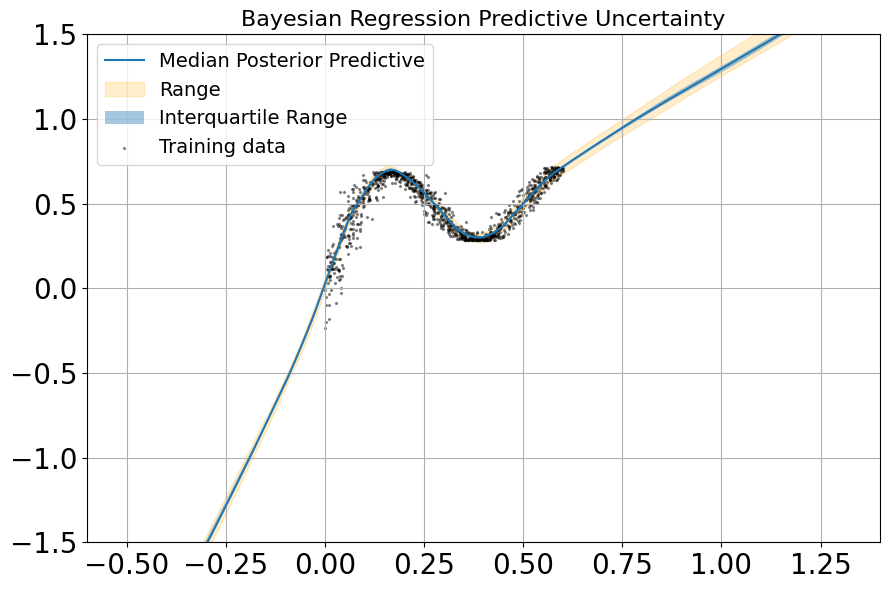

In [25]:
def reg_trainer():
    """Train and evaluate a Bayesian regression model on synthetic 1D data."""
    config = RegConfig

    # Generate synthetic regression data
    X, Y = create_data_reg(train_size=config.train_size)
    dataset = PrepareData(X, Y)
    train_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

    # Prepare model configuration
    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'batch_size': config.batch_size,
        'num_batches': len(train_loader),
        'x_shape': X.shape[1],
        'y_shape': Y.shape[1],
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'noise_tolerance': config.noise_tolerance,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    # Initialize model (BNN or MLP)
    model = BNN_Regression('bnn_regression', params)
    # model = MLP_Regression('mlp_regression', params)  # Uncomment to use standard MLP

    print(f"Initializing training on {device}...")

    # Training loop
    for epoch in tqdm(range(config.epochs)):
        model.train_step(train_loader)
        model.scheduler.step()

        # Track best model by loss
        if model.epoch_loss < model.best_loss:
            model.best_loss = model.epoch_loss
            # Optionally save model here
            # torch.save(model.net.state_dict(), 'best_model.pt')

    # Evaluation
    print("Evaluating and generating plots...")
    x_test = torch.linspace(-2., 2., config.num_test_points).reshape(-1, 1)

    # If loading saved model is needed:
    # model.net.load_state_dict(torch.load('best_model.pt', map_location=device))

    y_test = model.evaluate(x_test)

    # Visualization
    create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)

reg_trainer()

### Regression Trainer: MLP vs BNN (Switchable)

This function defines a full training pipeline for 1D regression using synthetic data.

Main steps:
- **Data Generation**: Creates noisy sinusoidal regression data.
- **Model Setup**: Initializes either a deterministic `MLP_Regression` or a probabilistic `BNN_Regression` (comment switchable).
- **Training Loop**: Optimizes the model over multiple epochs, tracking the best loss.
- **Evaluation**: Generates test predictions and plots the predictive output (with or without uncertainty, depending on model type).

To switch between MLP and BNN, simply comment/uncomment the corresponding model instantiation.

MLP Parameters:
  Batch size: 128
  Input shape: 1
  Hidden units: 400
  Output shape: 1
  Learning rate: 0.001
Initializing training on cuda...


100%|██████████| 1000/1000 [00:15<00:00, 64.85it/s]


Evaluating and generating plots...


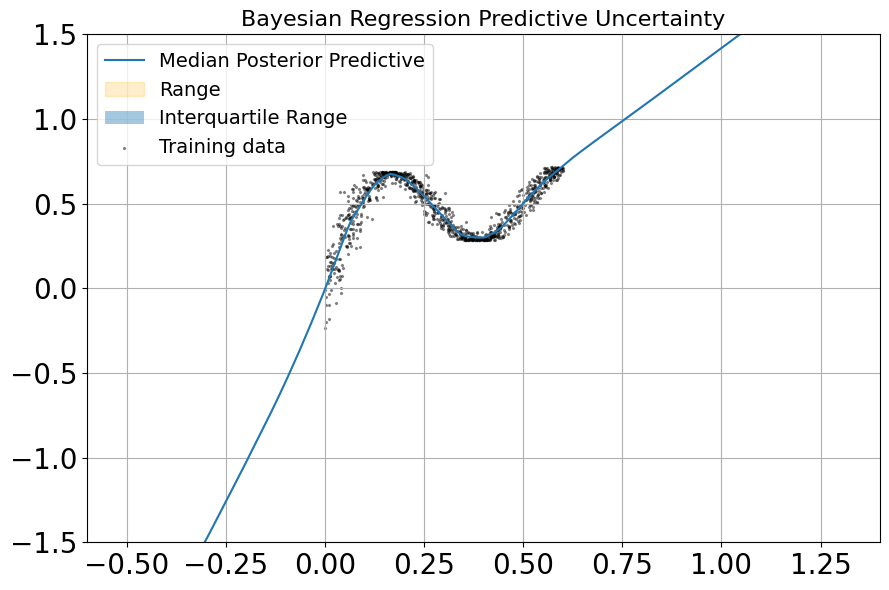

In [26]:
def reg_trainer():
    """Train and evaluate a regression model (MLP or BNN) on synthetic 1D data."""
    config = RegConfig

    # Generate synthetic regression dataset
    X, Y = create_data_reg(train_size=config.train_size)
    dataset = PrepareData(X, Y)
    train_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

    # Define model configuration parameters
    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'batch_size': config.batch_size,
        'num_batches': len(train_loader),
        'x_shape': X.shape[1],
        'y_shape': Y.shape[1],
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'noise_tolerance': config.noise_tolerance,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    # Choose model: MLP or BNN
    model = MLP_Regression('mlp_regression', params)
    # model = BNN_Regression('bnn_regression', params)

    print(f"Initializing training on {device}...")

    # Training loop
    for epoch in tqdm(range(config.epochs)):
        model.train_step(train_loader)
        model.scheduler.step()

        # Save best model based on training loss
        if model.epoch_loss < model.best_loss:
            model.best_loss = model.epoch_loss
            # torch.save(model.net.state_dict(), 'best_model.pt')  # Optional

    # Evaluate on test data
    print("Evaluating and generating plots...")
    x_test = torch.linspace(-2., 2., config.num_test_points).reshape(-1, 1)
    y_test = model.evaluate(x_test)

    # Visualization
    create_regression_plot(x_test.cpu().numpy(), y_test.reshape(1, -1), train_loader)
    # For BNN use: create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)

reg_trainer()